In [1]:
cd ..

/Users/samedi/Documents/Coding/Hakatons/CPCFO


In [3]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util
from back.recommender.utils import degree_centrality_scores
import pandas as pd
import numpy as np
import nltk
import re
import textwrap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
import io
from PIL import Image

In [16]:
sen_model = SentenceTransformer("cointegrated/LaBSE-en-ru")
stemmer = nltk.stem.snowball.SnowballStemmer("russian", True)
def stem(text): return ' '.join([ stemmer.stem(word) for word in nltk.word_tokenize(text)])
# def stem(text): return text

I = pd.read_csv('notebooks/cache/courses.csv', index_col=0)
Iembs = sen_model.encode((I['title'] + ' ' + I['description']).astype(str).apply(stem), convert_to_tensor=True)

nogos = ['bot','bot','офис','кофе','условия','трудоустройств','болезн','заработн','парковк',
         'дмс','неделя','отдых','карьер','высшее','serttifikat','сертификат','желание']

In [12]:
def wrap_xlabels(ax, width):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(
            re.sub('(?<=\w)\n(?=\w)','-\n', textwrap.fill(text, width=width, break_long_words=True, drop_whitespace=False)).replace('\n \n','\n')
            )
    ax.set_xticklabels(labels, rotation=0)

def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(
            textwrap.fill(text, width=width)
            )
    ax.set_yticklabels(labels, rotation=0)

def get_querry(body):
    querry = pd.Series(body.split('\n'))
    if querry.size <= 3:
        qs = []
        for q in querry.values:
            qs.extend(re.sub('[;.,]','\n', q).split('\n'))
        querry = pd.Series(qs)

    querry = querry[~querry.apply(lambda s: np.any([t in s.lower() for t in nogos]))]
    querry = querry.apply(lambda s: re.sub('^\d+\.?\s','',s)).drop_duplicates()
    querry = querry[querry.apply(lambda s: len(s.strip()) > 1)]
    return querry

def summarize(document, max_signs=30):
    words = nltk.word_tokenize(re.sub('\s+',' ', re.sub('[:;()!?<>.,\[\]\'\"`]',' ', str(document))))
    embeddings = sen_model.encode([stemmer.stem(word) for word in words], convert_to_tensor=True)
    cos_scores = util.cos_sim(embeddings, embeddings).cpu().numpy()
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)
    central_indices = np.argsort(-centrality_scores)
    signes_counter = 0
    for word_index, central_index in enumerate(central_indices):
        signes_counter += len(words[central_index].strip())
        if signes_counter > max_signs: break
    return ' '.join([words[i].strip() for i in range(len(words)) if i in central_indices[:word_index+1]])

def get_coherence_map(u) -> pd.DataFrame:
    u = pd.Series(u)
    querry = get_querry(u.body)
    qembs = sen_model.encode(list(map(stem, [u.title] + querry.values)), convert_to_tensor=True)
    sim = util.cos_sim(Iembs, qembs).cpu().numpy()

    rec_idxs = np.argsort(sim.sum(1))[:-5:-1]
    col_idxs = np.argsort(sim[rec_idxs[0]])[:-1-min(8,len(querry)):-1]

    columns = querry.iloc[col_idxs]
    try:
        columns = columns.apply(summarize)
    except:
        pass
    coherence_map = pd.DataFrame(sim[rec_idxs,][:,col_idxs], index=I.title[rec_idxs].values, columns=columns)
    return coherence_map

def show_coherence_map(coherence_map: pd.DataFrame, vmin=0, vmax=None, T=10, x0=0.45) -> None:
    fig, ax = plt.subplots(figsize=(20,6))
    sns.heatmap((1/(1 + np.exp((x0-coherence_map)*T))*100).astype(int), ax=ax, cmap='RdYlGn', annot=True, vmin=vmin, vmax=vmax)
    wrap_xlabels(ax, 8)
    wrap_ylabels(ax, 20)

def plot2image():
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png', bbox_inches='tight')
    plt.close()
    return Image.open(img_buf)

In [9]:
U = pd.read_csv('notebooks/cache/vacancy-skills-zeroshot.csv', index_col=0).merge(pd.read_csv('notebooks/cache/vacancies.csv', index_col=0), left_index=True, right_index=True)

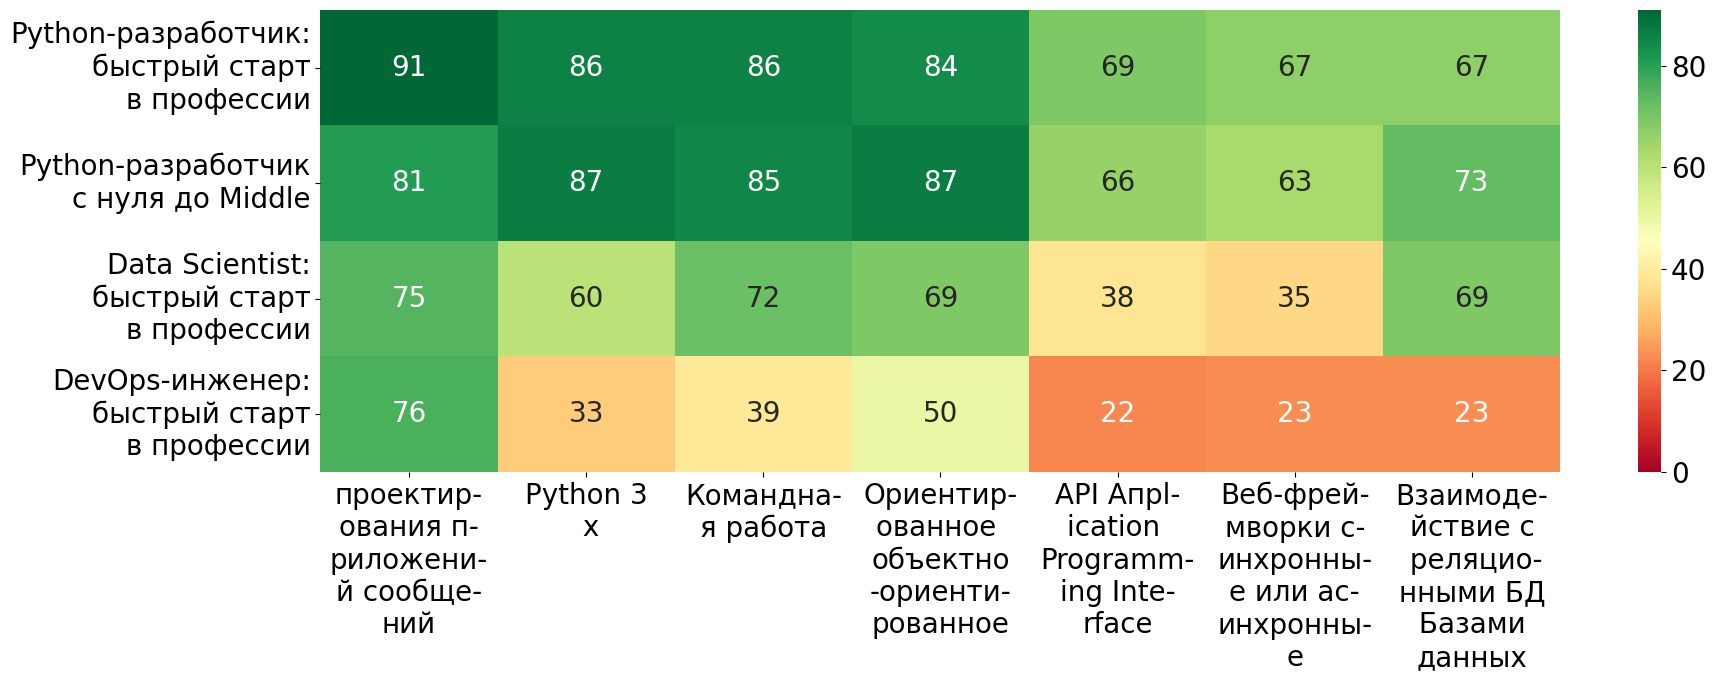

In [15]:
show_coherence_map(get_coherence_map(U.iloc[10]))
plot2image()

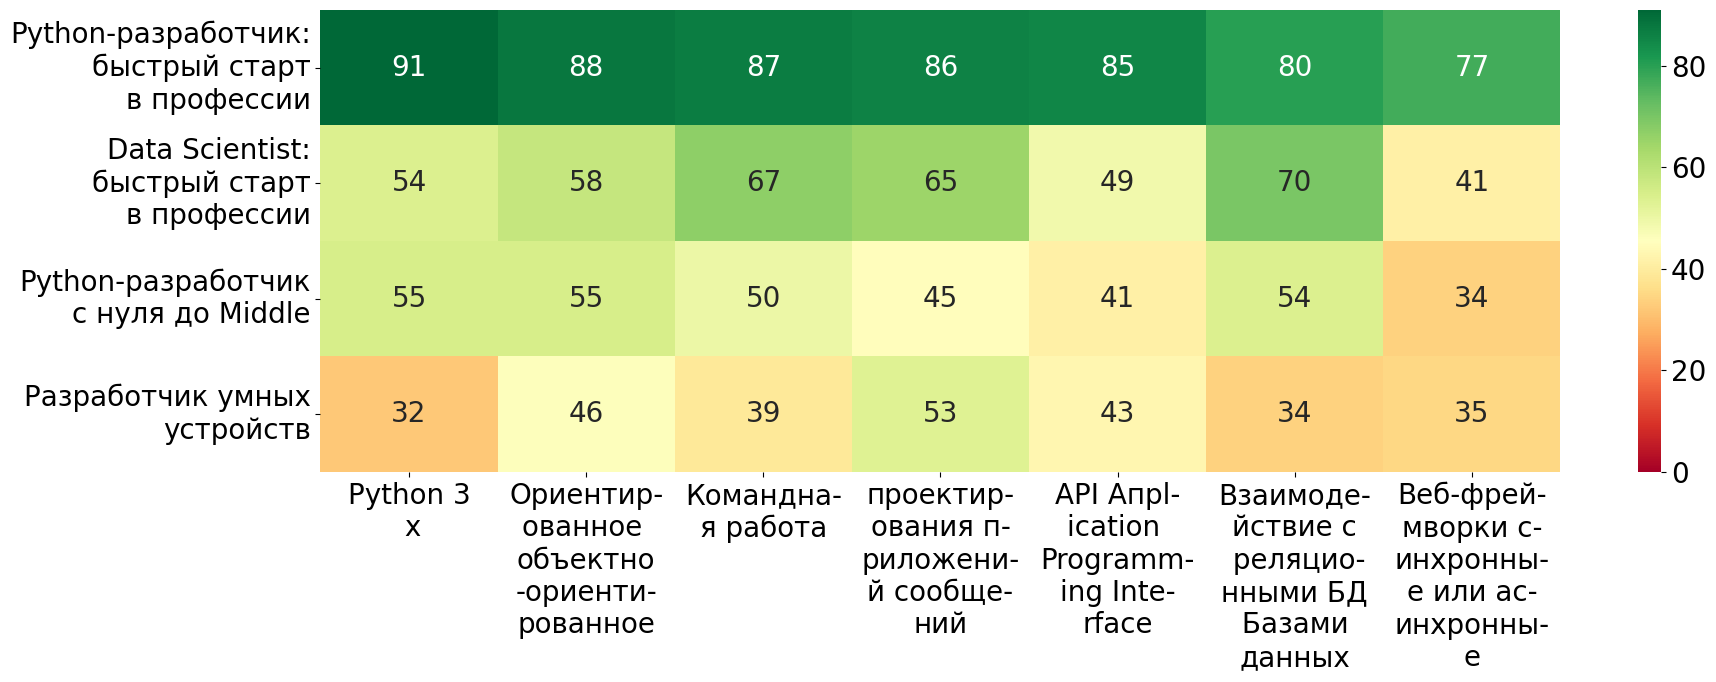

In [18]:
show_coherence_map(get_coherence_map(U.iloc[10]))
plot2image()